In [23]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.applications.vgg16 import VGG16
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import cv2

In [4]:
train_path = "/content/drive/MyDrive/recombined3/Train"
test_path = "/content/drive/MyDrive/recombined3/Test"

In [24]:
image_width = 224
image_height = 224
classes = ['Benign', 'Malignant']
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Resimleri yüklemek için flow_from_directory kullanın
train_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/recombined3/Train",
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Her sınıf için resimleri ayrı ayrı arttırın
for cls in classes:
    # Sınıfın resimlerini yüklemek için flow_from_directory kullanın
    cls_generator = datagen.flow_from_directory(
        directory="/content/drive/MyDrive/recombined3/Train",
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        classes=[cls]
    )

    # Resimleri arttırın ve kaydedin
    i = 0
    for batch in cls_generator:
        images, labels = batch
        for image in images:
            # Resmi kaydetmek için imwrite kullanın
            cv2.imwrite(os.path.join("/content/drive/MyDrive/recombined3/Train", cls, f"augmented_{i}.jpg"), image * 255)
            i += 1
            if i >= 6000:  # Maksimum resim sayısına ulaşıldığında döngüyü durdur
                break
        else:
            continue
        break

Found 670 images belonging to 2 classes.
Found 250 images belonging to 1 classes.
Found 420 images belonging to 1 classes.


In [5]:
img = load_img(train_path + "/Malignant/P001_22_RCC_RECOMBINED_1.jpg")

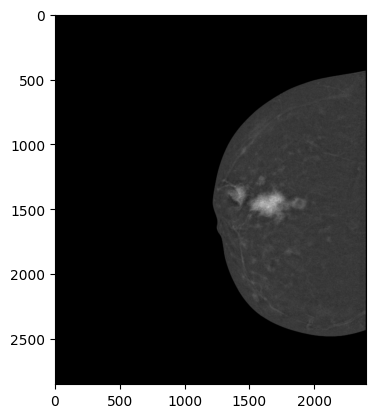

In [8]:
plt.imshow(img)

In [9]:
x = img_to_array(img)
print(x.shape)

(2850, 2396, 3)


In [10]:
numberOfClass = len(glob(train_path + "/*"))

In [11]:
vgg = VGG16()

553467096/553467096 [==============================] - 13s 0us/step


In [12]:
print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
print(type(vgg))

<class 'keras.src.engine.functional.Functional'>


In [15]:
vgg_layer_list = vgg.layers
print(vgg_layer_list)

[<keras.src.engine.input_layer.InputLayer object at 0x7a64196a4c70>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a6419866fe0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a6419867d60>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a6419865e10>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a64198660b0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a6419864c70>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a64194f3b50>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a64194f0b20>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a6419676200>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a64194f3d30>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a64174a45e0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a64196f3c40>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7a64174a5030>, <keras.src.layers.convolutional.co

En son layer'da 1000 çıktı gözüküyor default olarak. biz kendi çıktımız kadar yapacağımız için son katmanı siliyoruz.

In [16]:
model = Sequential()
for i in range(len(vgg_layer_list)-1):
  model.add(vgg_layer_list[i])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [19]:
for layers in model.layers:
  layers.trainable = False    #önceden yapılmış eğitimdeki ağırlıkları kullansın.

model.add(Dense(numberOfClass, activation="sigmoid"))

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [21]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [25]:
train_data = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224))
test_data = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224))

batch_size = 32

Found 12670 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [27]:
hist = model.fit(train_data,
                 epochs=30,
                 validation_data=test_data)

Epoch 1/30
396/396 [==============================] - 61s 153ms/step - loss: 0.6838 - accuracy: 0.6438
Epoch 2/30
396/396 [==============================] - 61s 153ms/step - loss: 0.6472 - accuracy: 0.6663
Epoch 3/30
396/396 [==============================] - 61s 154ms/step - loss: 0.6205 - accuracy: 0.6863
Epoch 4/30
396/396 [==============================] - 60s 152ms/step - loss: 0.6096 - accuracy: 0.6919
Epoch 5/30
396/396 [==============================] - 59s 149ms/step - loss: 0.5891 - accuracy: 0.7027
Epoch 6/30
396/396 [==============================] - 62s 155ms/step - loss: 0.5747 - accuracy: 0.7094
Epoch 7/30
396/396 [==============================] - 64s 162ms/step - loss: 0.5689 - accuracy: 0.7182
Epoch 8/30
396/396 [==============================] - 60s 152ms/step - loss: 0.5594 - accuracy: 0.7246
Epoch 9/30
396/396 [==============================] - 59s 149ms/step - loss: 0.5586 - accuracy: 0.7239
Epoch 10/30
396/396 [==============================] - 59s 149ms/step - l

In [28]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

4/4 [==============================] - 3s 702ms/step - loss: 1.0446 - accuracy: 0.5900
Test Loss: 1.0445877313613892
Test Accuracy: 0.5899999737739563


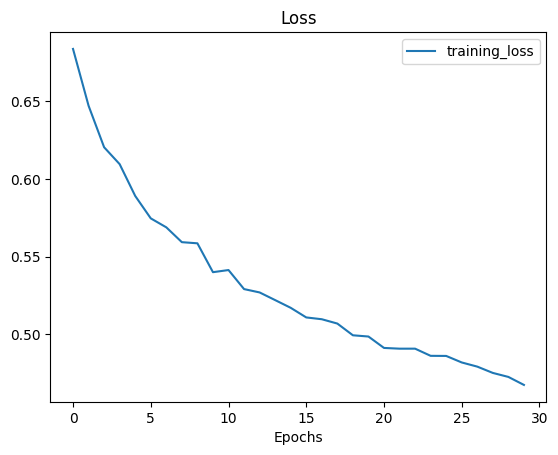

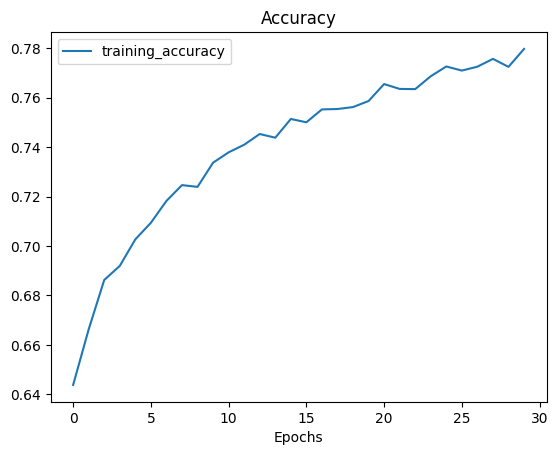

In [30]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']

  accuracy = history.history['accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(hist)